### Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

plt.style.use('fivethirtyeight')
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#### Create dataframe from csv

In [2]:
df = pd.read_csv('/home/nick/Documents/data/usa_00007.csv')
df

FileNotFoundError: [Errno 2] File /home/nick/Documents/data/usa_00007.csv does not exist: '/home/nick/Documents/data/usa_00007.csv'

While looking through the dataset, I noticed some variations of 999999 in the rows. Consulting the IPUMS codes, it turned out these were for non-responses. I did some cleaning by changing those entries to NaN, then dropping all NaN rows.

In [8]:
df.replace({9999999: np.NaN, 9999998: np.NaN, 99999:np.NaN, 999999:np.NaN}, inplace=True)
df.dropna(inplace=True)

Here I'm binary encoding the target variable - 1 if the respondent makes > $50K/yr, 0 if they do not.

In [9]:
df['>50K'] = df['INCTOT'].apply(lambda x: 1 if x > 50000 else 0)
df

YEAR    SAMPLE     SERIAL      CBSERIAL  NUMPREC  SUBSAMP   HHWT  \
2292     2018.0  201801.0     2293.0  2.018000e+12      2.0      0.0  192.0   
2293     2018.0  201801.0     2293.0  2.018000e+12      2.0      0.0  192.0   
2294     2018.0  201801.0     2294.0  2.018000e+12      4.0     27.0   36.0   
2295     2018.0  201801.0     2294.0  2.018000e+12      4.0     27.0   36.0   
2297     2018.0  201801.0     2294.0  2.018000e+12      4.0     27.0   36.0   
...         ...       ...        ...           ...      ...      ...    ...   
3214529  2018.0  201801.0  1410973.0  2.018001e+12      2.0     77.0   80.0   
3214530  2018.0  201801.0  1410973.0  2.018001e+12      2.0     77.0   80.0   
3214531  2018.0  201801.0  1410974.0  2.018001e+12      5.0     16.0  102.0   
3214532  2018.0  201801.0  1410974.0  2.018001e+12      5.0     16.0  102.0   
3214538  2018.0  201801.0  1410976.0  2.018001e+12      1.0     48.0   75.0   

         HHTYPE       CLUSTER    ADJUST  ...  TRANWORK  CARPOOL  RIDERS  \
2292        1.0  2.018000e+12  1.013097  ...      70.0      0.0     0.0   
2293        1.0  2.018000e+12  1.013097  ...      10.0      1.0     1.0   
2294        1.0  2.018000e+12  1.013097  ...      10.0      1.0     1.0   
2295        1.0  2.018000e+12  1.013097  ...      10.0      1.0     1.0   
2297        1.0  2.018000e+12  1.013097  ...       0.0      0.0     0.0   
...         ...           ...       ...  ...       ...      ...     ...   
3214529     1.0  2.018014e+12  1.013097  ...      10.0      1.0     1.0   
3214530     1.0  2.018014e+12  1.013097  ...       0.0      0.0     0.0   
3214531     9.0  2.018014e+12  1.013097  ...      10.0      1.0     1.0   
3214532     9.0  2.018014e+12  1.013097  ...      10.0      1.0     1.0   
3214538     4.0  2.018014e+12  1.013097  ...       0.0      0.0     0.0   

         TRANTIME  DEPARTS  ARRIVES  GCHOUSE  GCMONTHS  GCRESPON  >50K  
2292          0.0      0.0      0.0      1.0       0.0       0.0     1  
2293         40.0    652.0    734.0      1.0       0.0       0.0     0  
2294         20.0    512.0    534.0      1.0       0.0       0.0     0  
2295         20.0    717.0    739.0      1.0       0.0       0.0     0  
2297          0.0      0.0      0.0      1.0       0.0       0.0     0  
...           ...      ...      ...      ...       ...       ...   ...  
3214529      15.0    632.0    649.0      1.0       0.0       0.0     0  
3214530       0.0      0.0      0.0      1.0       0.0       0.0     0  
3214531      20.0    647.0    709.0      1.0       0.0       0.0     0  
3214532      11.0    747.0    759.0      1.0       0.0       0.0     0  
3214538       0.0      0.0      0.0      1.0       0.0       0.0     1  

[1828069 rows x 264 columns]

I lost the exact place where I saved this pickle file `'select_cols.p'`, but it was my go-to after trimming down the features from the original 264 down to 58. I've included another notebook called "extra modelling" that includes the sample testing I did with a sampled subset of the data (50,000 rows) for much faster model testing. The results are different enough from the full 1,828,069 rows as to be statistically significant, so models run on the subset couldn't be used for final results, but were a good baseline / starting point.

In [4]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)
    

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)
tw

UHRSWORK     OCC  DEGFIELDD  EDUC  WKSWORK2     VALUEH  OWNCOST  \
2172857      40.0  4700.0        0.0   7.0       3.0   250000.0    350.0   
2824614       0.0     0.0        0.0   6.0       0.0    70000.0    803.0   
3207636      30.0   440.0     3600.0  11.0       6.0   295000.0   2130.0   
2481197      16.0  4110.0        0.0   5.0       4.0   500000.0   3200.0   
2952487       6.0  4621.0        0.0   8.0       5.0   320000.0   1456.0   
...           ...     ...        ...   ...       ...        ...      ...   
2515097       0.0  4130.0        0.0   6.0       0.0   150000.0   1120.0   
2135777      40.0  2040.0        0.0   2.0       6.0   200000.0    980.0   
381164       56.0  3740.0        0.0   7.0       6.0  1000000.0   5115.0   
1461574      28.0  9620.0     2102.0  10.0       6.0   650000.0   2300.0   
127713       20.0  4350.0        0.0   7.0       6.0   199000.0    272.0   

         DEGFIELD  EDUCD   AGE  ...  WRKLSTWK  PWMET13  REGION  EMPSTATD  \
2172857       0.0   71.0  58.0  ...       2.0      0.0    31.0      10.0   
2824614       0.0   64.0  35.0  ...       1.0      0.0    33.0      30.0   
3207636      36.0  114.0  24.0  ...       2.0  33460.0    21.0      10.0   
2481197       0.0   50.0  19.0  ...       3.0  37980.0    12.0      10.0   
2952487       0.0   81.0  62.0  ...       2.0  41620.0    41.0      10.0   
...           ...    ...   ...  ...       ...      ...     ...       ...   
2515097       0.0   63.0  19.0  ...       1.0      0.0    12.0      20.0   
2135777       0.0   23.0  37.0  ...       2.0      0.0    31.0      10.0   
381164        0.0   71.0  38.0  ...       2.0  41740.0    42.0      10.0   
1461574      21.0  101.0  59.0  ...       2.0      0.0    11.0      10.0   
127713        0.0   71.0  19.0  ...       2.0      0.0    33.0      10.0   

         WORKEDYR  CBPERNUM  PWMET13ERR  YNGCH  BEDROOMS  >50K  
2172857       3.0       1.0         0.0   39.0       4.0   0.0  
2824614       1.0       2.0         0.0   99.0       4.0   0.0  
3207636       3.0       3.0         5.0   99.0       5.0   0.0  
2481197       3.0       3.0         3.0   99.0       5.0   0.0  
2952487       3.0       1.0         4.0   99.0       4.0   0.0  
...           ...       ...         ...    ...       ...   ...  
2515097       2.0       3.0         0.0   99.0       4.0   0.0  
2135777       3.0       2.0         0.0   15.0       4.0   0.0  
381164        3.0       1.0         1.0    5.0       5.0   1.0  
1461574       3.0       1.0         0.0   18.0       5.0   0.0  
127713        3.0       3.0         0.0   99.0       4.0   0.0  

[50000 rows x 58 columns]

### Class imbalance Alert!!

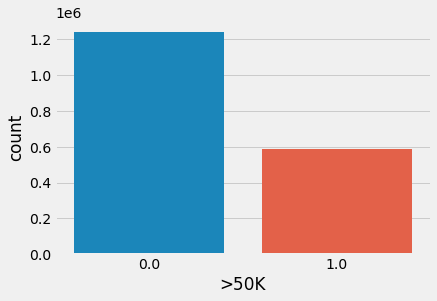

In [12]:
sns.countplot(selected_columns['>50K'])

### Solution: Near Miss Undersampling

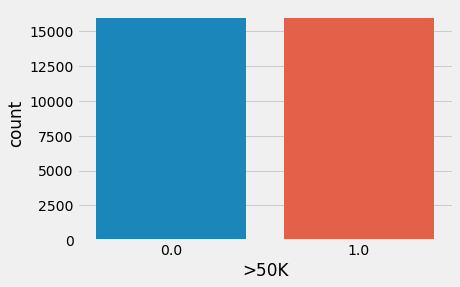

In [13]:
nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)
resampled_X, resampled_y = nm1.fit_resample(tw.iloc[:, :-1], tw.iloc[:, -1:])

sns.countplot(resampled_y['>50K'])

I'm not sure if it was an idiosyncrasy with my dataset, but correcting for class imbalance negatively impacted my r2 scores, in some cases massively. The one exception was with logistic regression, but that wasn't Near Miss undersampling - instead, I passed the parameter `class_weight='balanced'` to `LogisticRegression()`. That class weight adjustment brought the logistic regression r2 from 66% on both train and test, to around 80% on both.

---
Below is a pretty sparse looking pairplot. There is a better looking pairplot included in the `extras` folder that already rendered. There was not enough time to render the pairplot for this EDA notebook (even on the much smaller `tw` set), but the pairplot was not very helpful to me anyway. I did not see many correlations or distributions where >50K and <50K were clearly demarcated.

In [5]:
sns.pairplot(tttw, hue='>50K')

/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/dis

A heatmap of correlations between the 58 features with a mask over the top diagonal for simpler visual interpretation.

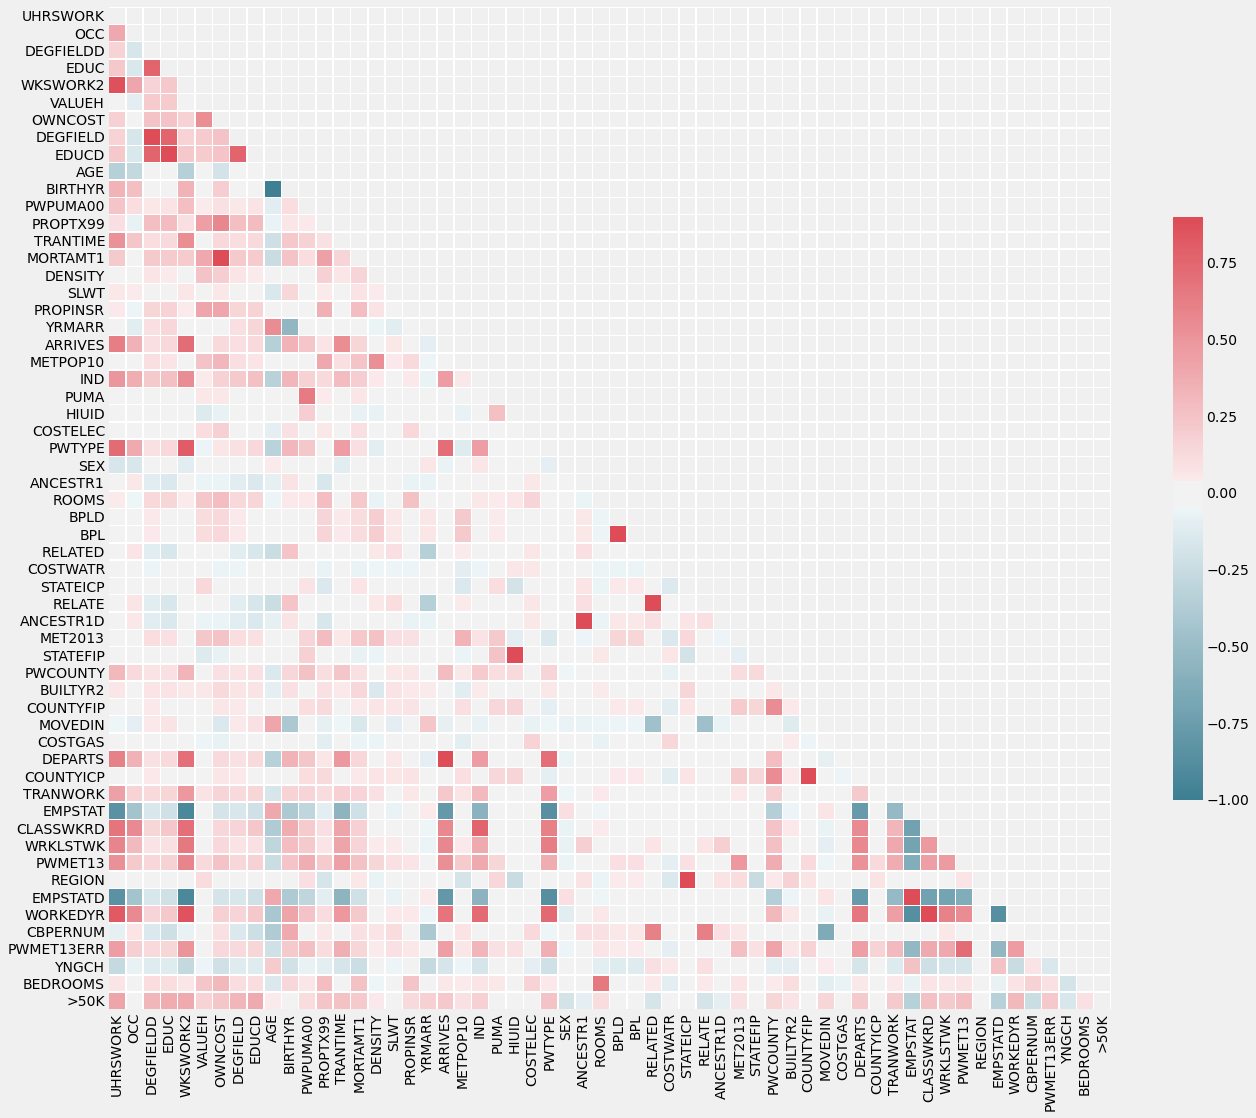

In [16]:
corr = tw.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=[20, 20])
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Finally, feature importances graph. It feels wrong including modelling in the EDA notebook, but the `feature_importances` graph was invaluable to me moving forward, and it was definitely part of my EDA. Please disregard the next two cells!

In [9]:
Xs = tw.drop(columns=['>50K'])
ys = tw.filter(['>50K'])

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(Xs_train, ys_train)

<ipython-input-10-77eb3430308c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Xs_train, ys_train)


RandomForestClassifier(n_jobs=-1)

But definitely don't disregard this next cell. Behold, `feature_importances` in all its glory:

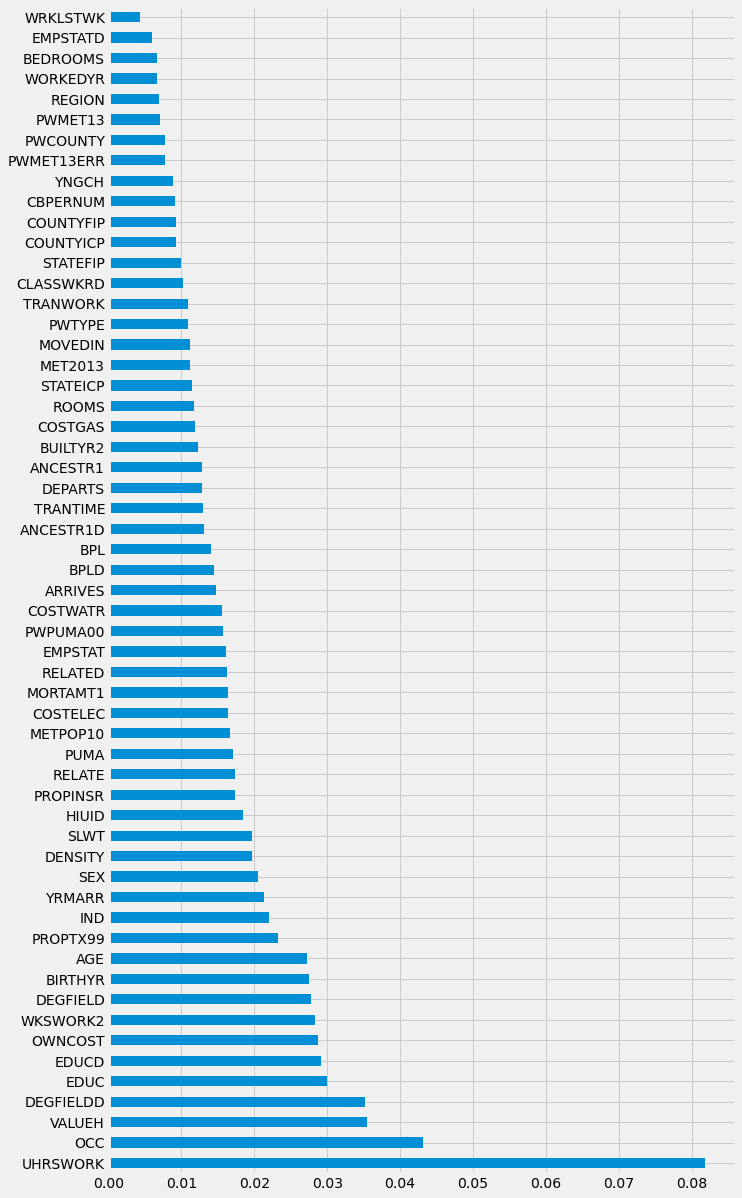

In [13]:
plt.figure(figsize=[10, 20])
importance = pd.Series(rf.feature_importances_, index=Xs.columns)
importance.nlargest(len(Xs.columns)).plot(kind='barh')

Looking at that graph, I felt pretty comfortable grabbing the top 10 features, more or less (I didn't include `EDUCD` because it was basically a duplicate of `EDUC` - the D stands for "detailed", but the columns were virtually identical, save for a few extra "outlier" values). I also didn't include `WKSWORK2` (number of weeks worked in the last year) because it seemed like a similar measurement to `UHRSWORK` (usual hours worked per week).